In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/UDEA-Esp-Analitica-y-Ciencia-de-Datos/EACD-06-MACHINE-LEARNING-II/master/init.py
import init; init.init(force_download=False); 

# Anomaly Detection Algorithms

# Dataset

Para aplicar las técnicas de detección de anomalías se trabajará con un dataset de dos descriptores tomados de un conjunto de servidores. Los descriptores son:<br>
 - throughput in mb/s
 - latency in ms of response for each server.

Nota: Este dataset fue tomado del curso de Machine learning de Andrew Ng de Coursera

El dataset consta de tres archivos csv, enunciados a continuación:

- **tr_server_data.csv**: datos de entrenamiento, dos descriptores, sin headers. La primera columna es la latencia y la segunda es el throughput. No tiene salida esperada.

- **cv_server_data.csv**: datos de cross-validation, dos descriptores, sin headers. La primera columna es la latencia y la segunda es el throughput. La salida esperada se encuentra en el archivo **gt_server_data.csv**.

- **gt_server_data.csv**: Salida esperada del dataset **cv_server_data.csv**. [1 es anormal y 0 es normal]

Se importa el dataset

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score
from sklearn.base import BaseEstimator, OutlierMixin
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal
from sklearn.neighbors import LocalOutlierFactor

In [78]:
columnas=['Latencia_ms','Throughput_mb_s']
tr_data = pd.read_csv('local/data/anomalies/tr_server_data.csv',header=None,names=columnas)
cv_data = pd.read_csv('local/data/anomalies/cv_server_data.csv',header=None,names=columnas)
gt_data = pd.read_csv('local/data/anomalies/gt_server_data.csv',header=None,names=['Target'])

In [79]:
print(tr_data.shape)

(307, 2)


In [80]:
tr_data.head()

,Latencia_ms,Throughput_mb_s
0,13.047,14.741
1,13.409,13.763
2,14.196,15.853
3,14.915,16.174
4,13.577,14.043


In [81]:
gt_data['Target'].value_counts()

0    298
1      9
Name: Target, dtype: int64

Grafiquemos el dataset de entrenamiento

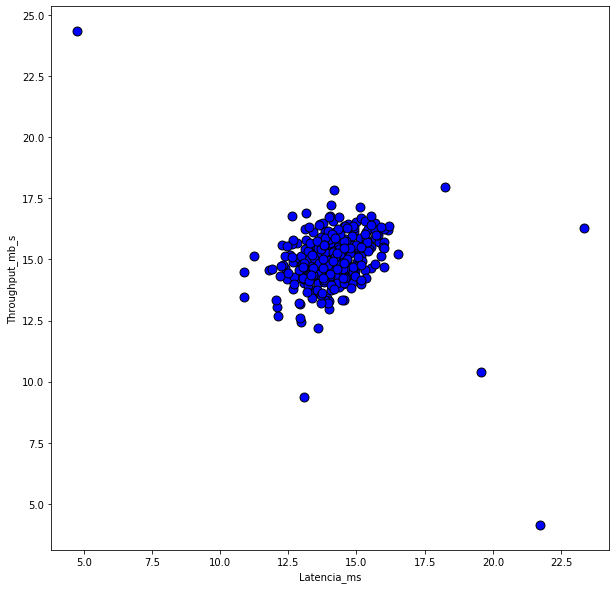

In [82]:
plt.figure(figsize=(10,10))
plt.xlabel('Latencia_ms')
plt.ylabel('Throughput_mb_s')
s = 80
b1 = plt.scatter(tr_data['Latencia_ms'],tr_data['Throughput_mb_s'], c='blue', s=s, edgecolors='k')
plt.show()

# Distribucion normal multivariada

Creemos la clase de nuestro modelo

In [84]:
class MultivariateNormalDistribution(BaseEstimator, OutlierMixin):
    """
    Algorithm for detecting outliers using the Multivariate Normal Distribution.
    An example is an outlier if the probability under the distribution is above
    some threshold.
    
    Parameters
    ----------
    ep : float, default=0.5
        when the evaluation of Multivariate Normal Distribution in a point is upper 
        to this value, that point is considered an outlier
    """
    def __init__(self, ep = 0.5):
        self.ep = ep    
    
    def fit(self, X=None, y=None):
        self.mu_ = np.mean(X, axis=0)
        self.sigma_ = np.cov(X.T)
        self.pmul = multivariate_normal(mean=self.mu_, cov=self.sigma_)
        return self
    
    def predict(self, X=None):
        p_ =  self.pmul.pdf(X)
        return np.asarray(np.where(p_ < self.ep, -1, 1), dtype=np.int64)

    def score_samples(self, X):
        return self.pmul.pdf(X)

In [93]:
outlierdetector = MultivariateNormalDistribution(ep = 9.036201327981216e-05)
outliers = outlierdetector.fit_predict(tr_data)

In [94]:
outlier_raws = outliers == -1

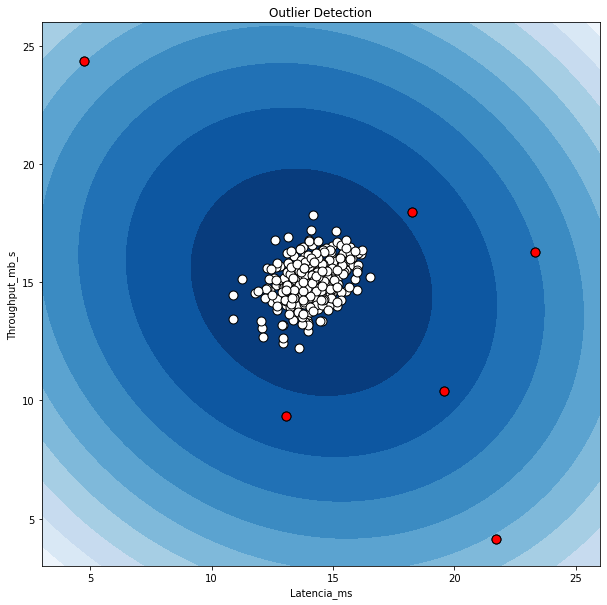

In [95]:
xx, yy = np.meshgrid(np.linspace(3, 26, 500), np.linspace(3, 26, 500))
Z = -np.log10(outlierdetector.score_samples(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10,10))
plt.title("Outlier Detection")
plt.contourf(xx, yy, Z,levels=11, cmap=plt.cm.Blues_r)
s = 80
b1 = plt.scatter(tr_data.values[:, 0], tr_data.values[:, 1], c='white', s=s, edgecolors='k')

c = plt.scatter(tr_data.values[outlier_raws,0],tr_data.values[outlier_raws,1], c='red', s=s,
                edgecolors='k')
plt.axis('tight')
plt.xlabel('Latencia_ms')
plt.ylabel('Throughput_mb_s')
plt.show()

# One-class SVM

In [97]:
clf = svm.OneClassSVM(nu=0.05, kernel="rbf", gamma=0.1)
clf.fit(tr_data)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.1, kernel='rbf',
            max_iter=-1, nu=0.05, shrinking=True, tol=0.001, verbose=False)

In [98]:
pred = clf.predict(tr_data)
abnormal = tr_data[pred == -1]

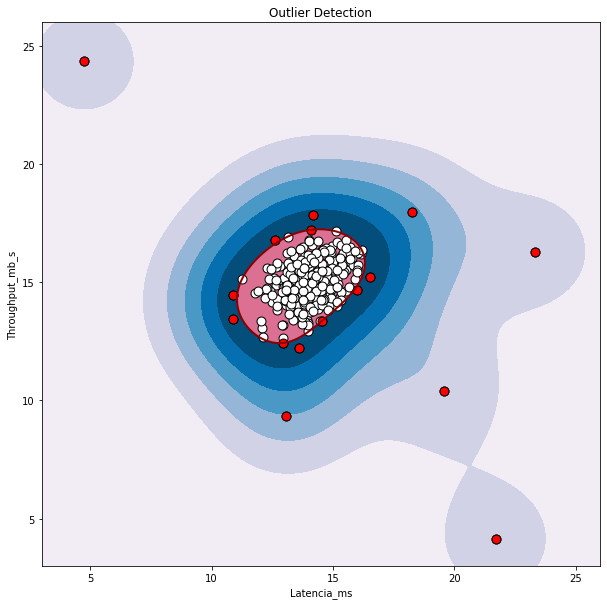

In [99]:
xx, yy = np.meshgrid(np.linspace(3, 26, 500), np.linspace(3, 26, 500))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(10,10))
plt.title("Outlier Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

s = 80
b1 = plt.scatter(tr_data.values[:, 0], tr_data.values[:, 1], c='white', s=s, edgecolors='k')

c = plt.scatter(abnormal['Latencia_ms'],abnormal['Throughput_mb_s'], c='red', s=s,
                edgecolors='k')
plt.axis('tight')
plt.xlabel('Latencia_ms')
plt.ylabel('Throughput_mb_s')
plt.show()

# Clustering KMeans y heuristicas

In [100]:
class KmeansOutlierDetector(BaseEstimator, OutlierMixin):
    """
    Algorithm for detecting outliers using kmeans and the
    distance between the points to their centroid. An example
    is an outlier if the distance to its centroid is above some
    threshold, which is computed as: q75 + (q75 - q25) * factor.

    Parameters
    ----------
    k : int, default=1
        The number of clusters to form as well as the number of centroids to
        generate
        
    factor : float, default=1.5
        a constant used to discern outliers used in the interquartile Rule to find
        outliers       
    """    
    
    def __init__(self, k=1,factor=1.5):
        self.k = k
        self.factor = factor 
    
    def fit(self, X=None, y=None):    
        if isinstance(X, pd.DataFrame):
            X_ = X.values 
        self.kmeans = KMeans(n_clusters=self.k).fit(X_)
        dist_ = self.score_samples(X)
        q75 = np.percentile(dist_, 75)
        q25 = np.percentile(dist_, 25)
        iqr = q75-q25
        self.threshold_ = q75+iqr*self.factor
        return self
    
    def predict(self, X=None):
        dist = self.score_samples(X)
        return np.asarray(np.where(dist >= self.threshold_, -1, 1), dtype=np.int64)
    
    def score_samples(self, X):
        if isinstance(X, pd.DataFrame):
            X_ = X.values
        X_clusters = self.kmeans.predict(X_)
        dist = np.linalg.norm(X_ - self.kmeans.cluster_centers_[X_clusters], axis=1)
        return dist

In [101]:
outlierdetector = KmeansOutlierDetector()

In [102]:
outlierdetector.fit(X=tr_data)

KmeansOutlierDetector(factor=1.5, k=1)

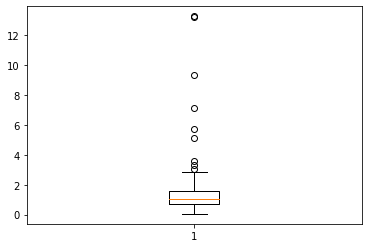

In [103]:
box_plot_data=outlierdetector.score_samples(tr_data)
plt.boxplot(box_plot_data)
plt.show()

In [104]:
outliers2 = outlierdetector.predict(X=tr_data)
outlier_raws = outliers2 == -1

Text(0, 0.5, 'Throughput_mb_s')

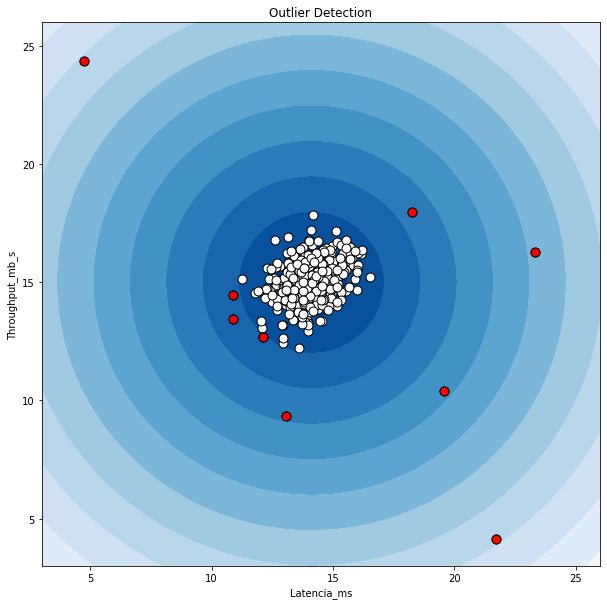

In [105]:
xx, yy = np.meshgrid(np.linspace(3, 26, 500), np.linspace(3, 26, 500))
Z = outlierdetector.score_samples(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10,10))
plt.title("Outlier Detection")
plt.contourf(xx, yy, Z,levels=11, cmap=plt.cm.Blues_r)
s = 80
b1 = plt.scatter(tr_data.values[:, 0], tr_data.values[:, 1], c='white', s=s, edgecolors='k')

c = plt.scatter(tr_data.values[outlier_raws,0],tr_data.values[outlier_raws,1], c='red', s=s,
                edgecolors='k')
plt.axis('tight')
plt.xlabel('Latencia_ms')
plt.ylabel('Throughput_mb_s')

# Isolation Forest

In [106]:
clf = IsolationForest(n_estimators=20, warm_start=True)
clf.fit(tr_data)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=20,
                n_jobs=None, random_state=None, verbose=0, warm_start=True)

In [107]:
y_pred_train = clf.predict(tr_data)

In [108]:
normal = tr_data[pred == 1]
abnormal = tr_data[pred == -1]

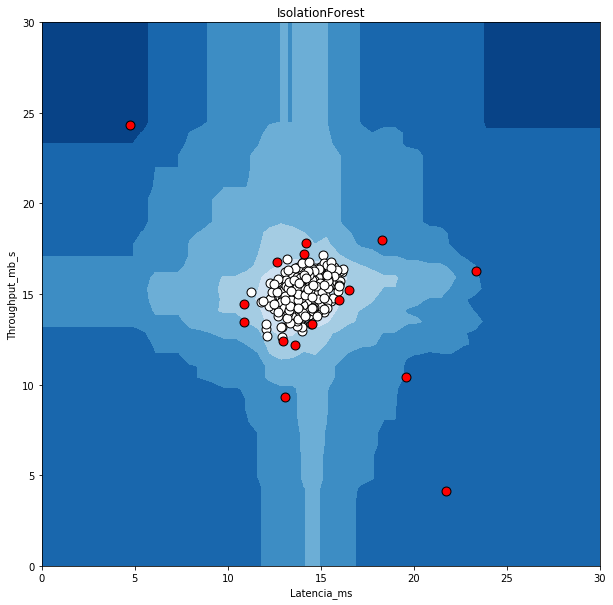

In [109]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_isolation_forest.html#sphx-glr-auto-examples-ensemble-plot-isolation-forest-py
# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(0, 30, 50), np.linspace(0, 30, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(10,10))
plt.title("IsolationForest")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

s = 80
b1 = plt.scatter(normal['Latencia_ms'],normal['Throughput_mb_s'], c='white',
                 s=s, edgecolor='k')

b2 = plt.scatter(abnormal['Latencia_ms'],abnormal['Throughput_mb_s'], c='red',
                 s=s, edgecolor='k')
plt.xlabel('Latencia_ms')
plt.ylabel('Throughput_mb_s')
plt.show()

# Local Outlier Factor

In [111]:
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)

In [112]:
y_pred = clf.fit_predict(tr_data)

In [113]:
normal = tr_data[pred == 1]
abnormal = tr_data[pred == -1]

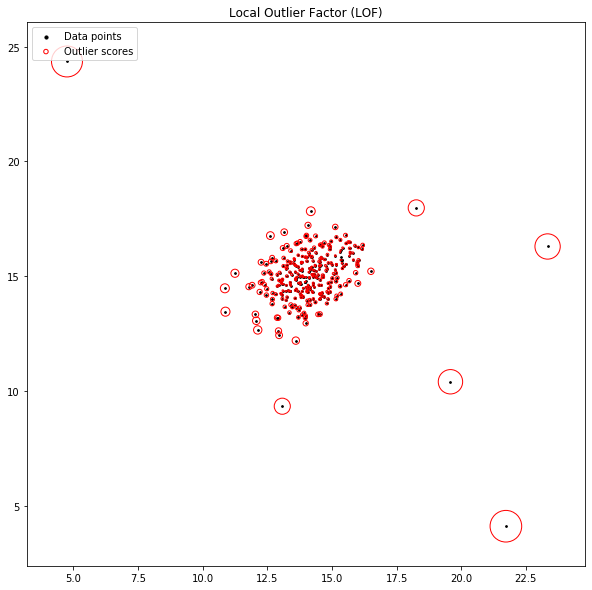

In [114]:
# https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_outlier_detection.html#sphx-glr-auto-examples-neighbors-plot-lof-outlier-detection-py
# use fit_predict to compute the predicted labels of the training samples
# (when LOF is used for outlier detection, the estimator has no predict,
# decision_function and score_samples methods).
y_pred = clf.fit_predict(tr_data)
X_scores = clf.negative_outlier_factor_
plt.figure(figsize=(10,10))
plt.title("Local Outlier Factor (LOF)")
plt.scatter(tr_data['Latencia_ms'],tr_data['Throughput_mb_s'], color='k', s=3., label='Data points')
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(tr_data['Latencia_ms'],tr_data['Throughput_mb_s'], s=1000 * radius, edgecolors='r',
            facecolors='none', label='Outlier scores')
plt.axis('tight')
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

# Aplica lo aprendido con en el siguiente problema

- Este dataset fue descargado del curso Detección de fraudes en Python de DataCamp.<br>
- El dataset contiene datos de transacciones de tarjetas de crédito.<br>
- Los casos de fraude son la clase minoritaria en estas transacciones. Qué metrica de desempeño usarias: precission, recall, F1-score, etc?<br>
- El nombre del archivo es: **banksim_adj.csv**
- la etiqueta esta en la columna "fraud".
- los descriptores es_XXX, indican el concepto en el que se encuentra enmarcada la transacción, ejemplo: es_food, indica que la transacción esta dentro del concepto de comida.

In [115]:
bankdata = pd.read_csv('local/data/anomalies/banksim_adj.csv')
bankdata.head()

,Unnamed: 0,age,amount,fraud,M,es_barsandrestaurants,es_contents,es_fashion,es_food,es_health,es_home,es_hotelservices,es_hyper,es_leisure,es_otherservices,es_sportsandtoys,es_tech,es_transportation,es_travel
0,0,3,49.71,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,1,4,39.29,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,2,3,18.76,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,3,4,13.95,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,4,2,49.87,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
